**IMPORTS**

In [19]:
import warnings
warnings.filterwarnings("ignore")
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import pickle

from gensim.parsing.preprocessing import STOPWORDS
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os

from collections import defaultdict




from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)


In [2]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"
import plotly.express as px
primary_green = px.colors.qualitative.Plotly[2]

In [3]:
#reading our dataset
df=pd.read_csv('Job titles and industries.csv')

In [4]:
df.shape

(8586, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [6]:
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [7]:
df.describe()

,job title,industry
count,8586,8586
unique,3890,4
top,marketing executive,IT
freq,91,4746


we can see from the value counts that the data is imbalanced

In [8]:
df['industry'].value_counts()

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: industry, dtype: int64

In [9]:
df['job title'].groupby(df['industry']).value_counts()

industry     job title                       
Accountancy  accounts assistant                  19
             assistant accountant                13
             finance assistant                    8
             management accountant                8
             trainee accountant                   8
                                                 ..
Marketing    web editor                           1
             web specialist                       1
             web technical support specialist     1
             website owner                        1
             wedding planning manager             1
Name: job title, Length: 3968, dtype: int64

In [10]:
df.isna().sum()

job title    0
industry     0
dtype: int64

<AxesSubplot:xlabel='industry', ylabel='count'>

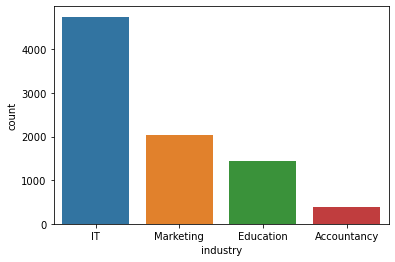

In [12]:
sns.countplot(x="industry", data=df)

In [14]:
it_df = df[df['industry'] == 'IT']['job title'].value_counts().sort_index()
market_df = df[df['industry'] == 'Marketing']['job title'].value_counts().sort_index()
edu_df = df[df['industry'] == 'Education']['job title'].value_counts().sort_index()
acc_df = df[df['industry'] == 'Accountancy']['job title'].value_counts().sort_index()
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=it_df.index,
#     y=it_df.values,
#     name='IT',
#     fill='tozeroy',
#     marker_color=primary_blue,
# ))
# fig.add_trace(go.Scatter(
#     x=market_df.index,
#     y=market_df.values,
#     name='Marketing',
#     fill='tozeroy',
#     marker_color=primary_blue2,
# ))
# fig.add_trace(go.Scatter(
#     x=edu_df.index,
#     y=edu_df.values,
#     name='Education',
#     fill='tozeroy',
#     marker_color=primary_blue3,
# ))
# fig.add_trace(go.Scatter(
#     x=acc_df.index,
#     y=acc_df.values,
#     name='Accountancy',
#     fill='tozeroy',
#     marker_color=primary_grey,
# ))
# fig.update_layout(
#     title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
# )
# fig.update_xaxes(range=[0, 70])
# fig.show()

**Preprocessing**

In [15]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['job title'] = df['job title'].map(clean_text)
df.head(20)

,job title,industry
0,technical support and helpdesk supervisor cou...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT
5,privileged access management expert,IT
6,devops engineers x global brand,IT
7,devops engineers x global brand,IT
8,data modeller,IT
9,php web developer £ based in london,IT


In [17]:
def process_(my_input):
    vect = CountVectorizer()
    my_input=vect.fit_transform(my_input)
    tfidf_transformer = TfidfTransformer()
    my_input=tfidf_transformer.fit_transform(my_input)
    return my_input
#we will use this later in the app.py

In [16]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
x = df['job title']
y = df['industry']


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

**Vectorization and TF-IDF**

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer(decode_error="replace")
x_train_dtm=vect.fit_transform(x_train)
pickle.dump(vect.vocabulary_,open("feature.pkl","wb"))

In [23]:
# vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("feature.pkl", "rb")))
tfidf_transformer = TfidfTransformer()

x_train_tfidf=tfidf_transformer.fit_transform(x_train_dtm)

x_test_tfidf = tfidf_transformer.transform(loaded_vec.fit_transform(x_test))


**Modeling**

In [26]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None,class_weight = "balanced")

sgd.fit(x_train_tfidf, y_train)

y_pred = sgd.predict(x_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))


accuracy 0.9222170470423847


In [27]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report
print('SGD classification_report\n', classification_report(y_test, y_pred))

0.9222170470423847
SGD classification_report
               precision    recall  f1-score   support

 Accountancy       0.81      0.84      0.83        93
   Education       0.95      0.84      0.89       366
          IT       0.95      0.96      0.96      1191
   Marketing       0.86      0.90      0.88       497

    accuracy                           0.92      2147
   macro avg       0.89      0.89      0.89      2147
weighted avg       0.92      0.92      0.92      2147



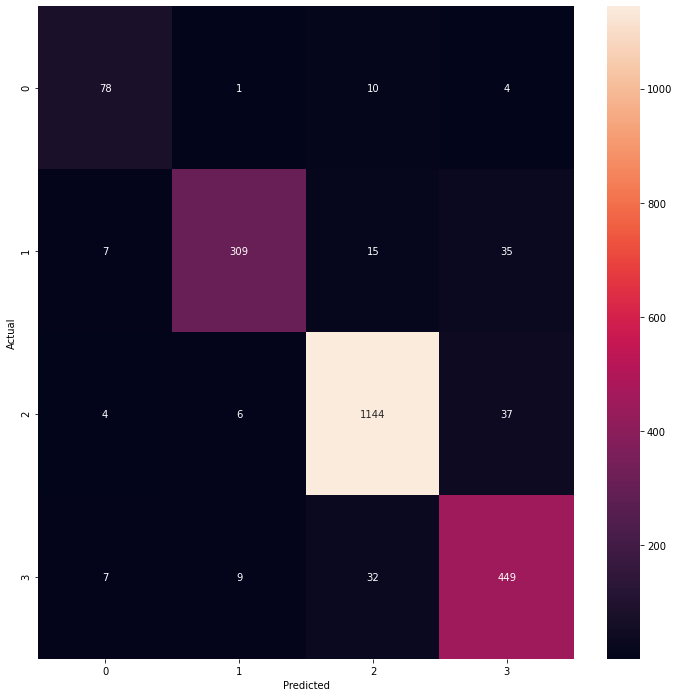

In [28]:
# import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
from xgboost import XGBClassifier

In [30]:
xgb=XGBClassifier(random_state=42, class_weight = "balanced")

xgb.fit(x_train_tfidf, y_train)

y_pred_x = xgb.predict(x_test_tfidf)


[14:08:43] WARNING: ..\src\learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [31]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_x))
from sklearn.metrics import classification_report
print('SGD classification_report\n', classification_report(y_test, y_pred_x))

0.9212855146716349
SGD classification_report
               precision    recall  f1-score   support

 Accountancy       0.96      0.73      0.83        93
   Education       0.90      0.86      0.88       366
          IT       0.95      0.97      0.96      1191
   Marketing       0.86      0.90      0.88       497

    accuracy                           0.92      2147
   macro avg       0.92      0.86      0.89      2147
weighted avg       0.92      0.92      0.92      2147



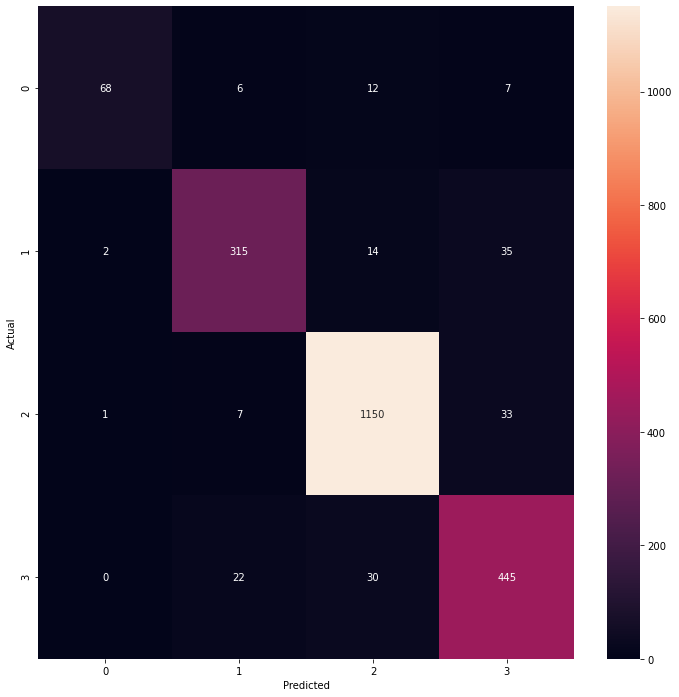

In [32]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_x)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

we will use the sgd classifier 

In [33]:
#Save the final selected Model to a file to use directly in the RESTfull API script.
from joblib import dump, load
dump(sgd, 'model.joblib')

['model.joblib']